# Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

import pandas as pd
import numpy as np
from datetime import datetime
import sys
sys.path.append('/content/drive/Shareddrives/NUTRECON/1. Acquisition/current_version/notebooks')

from nutrecon import *

subject_nr = 3

experiment_code = 'nutre'
dataPath = root[:-1] + "2. Data/raw/nutrecon/"
sequences_dataPath = dataPath + 'sequences/'
responses_dataPath = dataPath + 'responses/'

subject_code = '{}{:03d}'.format(experiment_code, subject_nr)

flavorCodes = {
    'blueberry' : 'g',
    'cashew' : 'c', 
    'dragon fruit': 'h',
    'ginseng' : 'i',
    'grapefruit': 'j',
    'licorice': 'k',
    'lychee': 'd', 
    'pomegranate': 'e' 
  }

imageCodes = {
    'Image I' : 'square',
    'Image II' : 'hexagon',
    'Image V' : 'circle',
    'Image VI' : 'cross'}

imageDecoder = {0: 'Image I',
                1: 'Image II',
                #2: 'Image III',
                #3: 'Image IV',
                4: 'Image V',
                5: 'Image VI'
                }

pres_order_fileID = 'day1_presOrder'
pres_order_colName = 'Presentation Order'
flavorName_colName = 'Flavor'
flavorID_colName = 'flavor_id'

pres_order_d2_fileID = 'day2_presOrder'
pres_order_d3_fileID = 'day3_presOrder'

flav_ratings_fileID = 'day1_rating'

intensity_colName = 'intensity'
novelty_colName = 'novelty'
pleasanteness_colName = 'pleasantness'

learn_order_fileID = 'day1_learnOrder'
learningOrder_colName = 'Learning order'
imageName_colName = 'image'
imageID_colName = 'image_id'

assocTestOrder1_colName = 'Day 1 - Association Test order'
assoc1_order_fileID = 'day1_atestOrder'

assocTestOrder2_colName = 'Day 2 - Association Test order'
assoc2_order_fileID = 'day2_atestOrder'

assocTestOrder3_colName = 'Day 3 - Association Test order'
assoc3_order_fileID = 'day3_atestOrder'

neuroEconOrder1_fileID = 'day2_neuroEconOrder'
neuroEconOrder2_fileID = 'day3_neuroEconOrder'


learning_path = glob('{}{}*{}*'.format(sequences_dataPath, subject_code, learn_order_fileID))[0]

learnig_df = pd.read_json(learning_path).T
learnig_df['Flavor'].tolist()

neuroEcon_id = '_neuroEcon'

neuroEcon_df = pd.read_json(glob('{}{}*{}*'.format(responses_dataPath, subject_code, neuroEcon_id))[0])
flavor_Cplus = neuroEcon_df[neuroEcon_df['Trial Type'] == 'mixed_yogurt'].iloc[0]['reference flavor']
flavor_Cminus = neuroEcon_df[neuroEcon_df['Trial Type'] == 'mixed_yogurt'].iloc[0]['lottery flavor']

marker_order = ['^' if flavor == flavor_Cplus else 'v' if flavor == flavor_Cminus else 'o' if flavor in learnig_df['Flavor'].tolist() else 'x' for flavor in list(flavorCodes.keys())]

ModuleNotFoundError: No module named 'google'

# Ratings

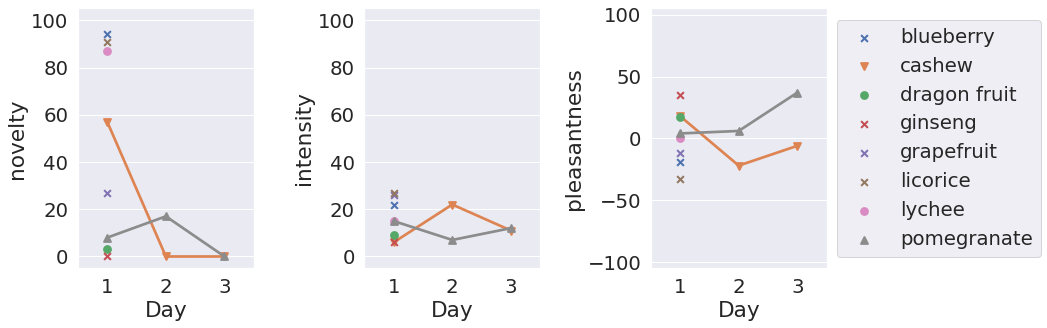

In [ ]:
from glob import glob

ratings_id = '_rating'
orders_id = '_presOrder'

ratings_paths = glob('{}{}*{}*'.format(responses_dataPath, subject_code, ratings_id))


marker_scale = 1
for ratings_path in ratings_paths:
  dayRating_df = pd.read_json(ratings_path)
  fpath, day, preOrder, timestamp =  ratings_path.split('_')
  order_path = glob('{}_{}{}*'.format(fpath.replace('responses', 'sequences'), day, orders_id))[0]
  dayOrder_df = pd.read_json(order_path).T
  dayOrder_df['Trial'] = np.arange(len(dayOrder_df)) + 1
  dayRating_df = dayRating_df.merge(dayOrder_df[[flavorName_colName, flavorID_colName, 'Trial']], left_on = 'Trial', right_on = 'Trial')
  if ratings_path == ratings_paths[0]:
    ratings_df = dayRating_df
  else:
    ratings_df = pd.concat([ratings_df, dayRating_df])

sns.set_theme(font_scale = 1.8)
fig, ax = plt.subplots(ncols = 3, figsize = [15,5])

sns.pointplot(data = ratings_df, x = 'Day', y = novelty_colName, hue = flavorName_colName, hue_order = list(flavorCodes.keys()),
              markers = marker_order, scale=marker_scale, order = [1,2,3], ax = ax[0], legend = False)
ax[0].set_ylim([-5,105]);
ax[0].get_legend().remove();

sns.pointplot(data = ratings_df, x = 'Day', y = intensity_colName, hue = flavorName_colName, hue_order = list(flavorCodes.keys()),
              markers = marker_order, scale=marker_scale, order = [1,2,3], ax = ax[1])
ax[1].set_ylim([-5,105]);
ax[1].get_legend().remove();

sns.pointplot(data = ratings_df, x = 'Day', y = pleasanteness_colName, hue = flavorName_colName, hue_order = list(flavorCodes.keys()),
              markers = marker_order, scale=marker_scale, order = [1,2,3], ax = ax[2])
ax[2].set_ylim([-105,105]);
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

fig.savefig('ratings.png')



# Association Tests

			Accuracy: 0.8333333333333334


precision    recall  f1-score        Flavor
criteria      image_id flavor_id                                             
in compliance Image II c           1.000000  1.000000  1.000000        cashew
              Image I  e           0.857143  1.000000  0.923077   pomegranate
              Image V  d           0.800000  0.666667  0.727273        lychee
              Image VI h           0.666667  0.666667  0.666667  dragon fruit

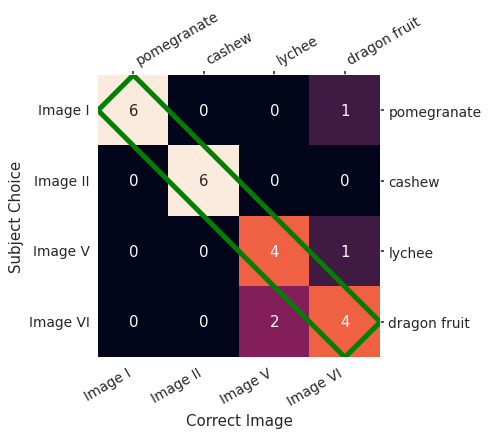

In [ ]:
sns.set_theme(font_scale = 1)

min_correctResp = 4
associationTest1_df, _ = loadResponses(sequences_dataPath, assoc1_order_fileID, subject_code)
imageFlavor_df, _ = loadResponses(sequences_dataPath, learn_order_fileID, subject_code)
flavorImage_code = {p[imageID_colName]:p[flavorName_colName] for p in imageFlavor_df.T[[imageID_colName, flavorName_colName]].to_dict('index').values()}
atest_day1_sequence = [get_key(imageDecoder,p) for p in associationTest1_df.T['image_id'].tolist()]
atest_day1_responses, _ = loadResponses(responses_dataPath, 'day1_atest', subject_code)

fig, report = reportAndConfusionMatrix(atest_day1_sequence, atest_day1_responses['image_id'].tolist(), flavorImage_code)
plt.tight_layout()
fig.savefig('atest1.png', transparent=True)
check_atest(report, flavorImage_code, min_correctResp)

			Accuracy: 1.0


precision  recall  f1-score       Flavor
criteria      image_id flavor_id                                          
in compliance Image I  e                1.0     1.0       1.0  pomegranate
              Image II c                1.0     1.0       1.0       cashew

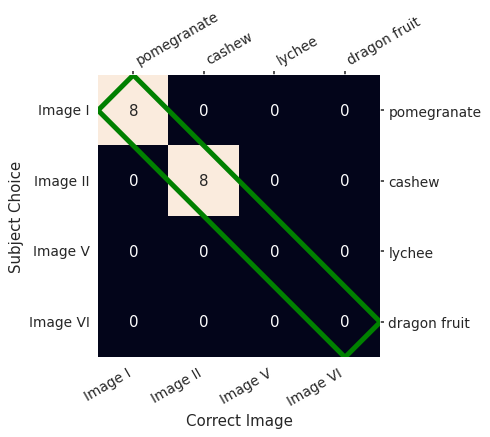

In [ ]:
min_correctResp = 7
associationTest2_df, _ = loadResponses(sequences_dataPath, assoc2_order_fileID, subject_code)
imageFlavor_df, _ = loadResponses(sequences_dataPath, learn_order_fileID, subject_code)
flavorImage_code = {p[imageID_colName]:p[flavorName_colName] for p in imageFlavor_df.T[[imageID_colName, flavorName_colName]].to_dict('index').values()}
atest_day2_sequence = [get_key(imageDecoder,p) for p in associationTest2_df.T['image_id'].tolist()]
atest_day2_responses, _ = loadResponses(responses_dataPath, 'day2_atest', subject_code)

fig, report = reportAndConfusionMatrix(atest_day2_sequence, atest_day2_responses['image_id'].tolist(), flavorImage_code)
plt.tight_layout()
fig.savefig('atest2.png', transparent=True)
check_atest(report, flavorImage_code, min_correctResp)

			Accuracy: 1.0


precision  recall  f1-score       Flavor
criteria      image_id flavor_id                                          
in compliance Image I  e                1.0     1.0       1.0  pomegranate
              Image II c                1.0     1.0       1.0       cashew

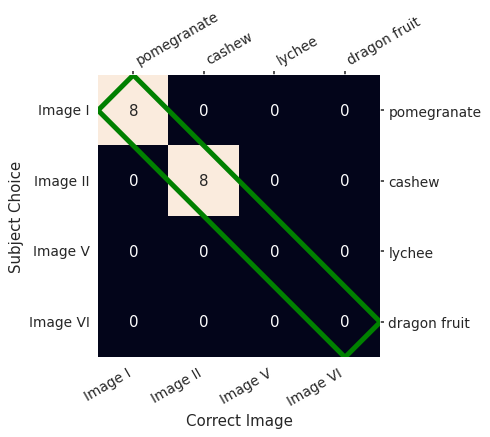

In [ ]:
min_correctResp = 7

associationTest3_df, _ = loadResponses(sequences_dataPath, assoc3_order_fileID, subject_code)
imageFlavor_df, _ = loadResponses(sequences_dataPath, learn_order_fileID, subject_code)
flavorImage_code = {p[imageID_colName]:p[flavorName_colName] for p in imageFlavor_df.T[[imageID_colName, flavorName_colName]].to_dict('index').values()}
atest_day3_sequence = [get_key(imageDecoder,p) for p in associationTest3_df.T['image_id'].tolist()]
atest_day3_responses, _ = loadResponses(responses_dataPath, 'day3_atest', subject_code)

fig, report = reportAndConfusionMatrix(atest_day3_sequence, atest_day3_responses['image_id'].tolist(), flavorImage_code)
plt.tight_layout()
fig.savefig('atest3.png', transparent=True)
check_atest(report, flavorImage_code, min_correctResp)

# Reaction times

In [ ]:

neuroEcon_id = '_neuroEcon'

neuroEcon_paths = glob('{}{}*{}*'.format(responses_dataPath, subject_code, neuroEcon_id))
neuroEcon_path = neuroEcon_paths[0]

for neuroEcon_path in neuroEcon_paths:
  dayNeuroEcon_df = pd.read_json(neuroEcon_path)
  if neuroEcon_path == neuroEcon_paths[0]:
    neuroEcon_df = dayNeuroEcon_df
  else:
    neuroEcon_df = pd.concat([neuroEcon_df, dayNeuroEcon_df])
neuroEcon_df['reaction_time'] = neuroEcon_df['choiceTime_ms'] - neuroEcon_df['choiceStart_ms']
neuroEcon_df['Day'] = neuroEcon_df['Day'].apply(lambda day: int(day[-1]))

neuroEcon_df.columns



Index(['Day', 'Trial', 'Trial ID', 'Trial Type', 'User', 'block', 'choice',
       'choiceStart_ms', 'choiceTime', 'choiceTime_ms', 'feedbackTime',
       'lottery flavor', 'lottery p', 'lottery qt', 'lottery shape',
       'lottery type', 'optionTime', 'reference flavor', 'reference p',
       'reference qt', 'reference shape', 'reference type',
       'trialStartTimestamp', 'trialStart_ms', 'reaction_time'],
      dtype='object')

In [2]:
sns.set_theme(font_scale = 1.2)
fig, ax = plt.subplots(ncols = 2, figsize = [15,3], sharey = True, sharex = True)
c = 0
for day in neuroEcon_df['Day'].unique():
  sns.histplot(data = neuroEcon_df[neuroEcon_df['Day'] == day], x = 'reaction_time', ax = ax[c])
  ax[c].set_title('Day {}'.format(day))
  c+=1
plt.tight_layout()
fig.savefig('reaction_time.png')

NameError: name 'sns' is not defined

In [3]:
sns.set_theme(font_scale = .8)
fig, ax = plt.subplots(ncols = 2, nrows = len(neuroEcon_df['block'].unique()), figsize = [15,10], sharex = True, sharey = True)

row = 0

for block in neuroEcon_df['block'].unique():
  df_ = neuroEcon_df[neuroEcon_df['block'] == block]  
  col = 0
  for day in df_['Day'].unique():
    block_type = df_[df_['Day'] == day]['Trial Type'].tolist()[0]
    if block_type == 'same':
      color = 'blue'
    else:
      block_type = 'mixed'
      color = 'orange'
    sns.histplot(data = df_[df_['Day'] == day], x = 'reaction_time', ax = ax[row, col],  binwidth=50, color = color)
    ax[row,col].set_ylabel('')
    ax[row,col].text(1,1,block_type, ha='right', va = 'top', transform = ax[row,col].transAxes)
    col+=1
  ax[row,0].set_ylabel('block {}'.format(block + 1))
    
  row += 1

ax[0,0].set_title('Day 2')
ax[0,1].set_title('Day 3')
plt.tight_layout(h_pad = -.5)
fig.savefig('block_reactionTime.png')

NameError: name 'sns' is not defined

# Mixed iogurt preference

In [4]:
c_palette = sns.color_palette()

sns.set_theme(font_scale = 1)
def get_reward_choice(row):
  if row['choice'] == 1:
    reward = row['reference type']
  elif row['choice'] == 2:
    reward = row['lottery type']
  else:
    reward = ''

  return reward

neuroEcon_df['chosen reward'] = neuroEcon_df.apply(lambda row: get_reward_choice(row), axis = 1)
df = neuroEcon_df[neuroEcon_df['Trial Type'] == 'mixed_yogurt']
fig, ax = plt.subplots(figsize = [3,3])
sns.countplot(data=df[df['Day'] == 2 ], x='chosen reward', order = ['C+', 'C-']);
plt.tight_layout()
fig.savefig('mixedYogurt_choicesD2.png')

grid = sns.FacetGrid(data=df[df['Day'] == 2 ], row = 'reference p', col = 'lottery p',height=2,aspect=1, margin_titles = True, sharey = True)
fig = grid.map_dataframe(sns.countplot, x='chosen reward', order = ['C+', 'C-'], palette = c_palette[:2])
fig.add_legend()

fig, ax = plt.subplots(figsize = [3,3])
sns.countplot(data=df[df['Day'] == 3 ], x='chosen reward', order = ['C+', 'C-']);
plt.tight_layout()
fig.savefig('mixedYogurt_choicesD3.png')

grid = sns.FacetGrid(data=df[df['Day'] == 3 ], row = 'reference p', col = 'lottery p',height=2,aspect=1, margin_titles = True, sharey = True)
fig = grid.map_dataframe(sns.countplot, x='chosen reward', order = ['C+', 'C-'], palette = c_palette[:2])
fig.add_legend()


NameError: name 'sns' is not defined

# Parameter estimation

In [ ]:
column_names = ['reference type', 'reference qt', 'reference p',
                'lottery type', 'lottery qt', 'lottery p',
                'ref_alpha', 'lott_alpha', 'beta',
                'ref_EU', 'lott_EU', 'pL', 'choice',
                'ref_alphaEstimates', 'lott_alphaEstimates', 'betaEstimates',
                'ref_alphaEstimStdErr', 'lott_alphaEstimStdErr', 'betaEstimStdErr']

optimize_cols = column_names[:6]  + [column_names[12]]
optimize_cols

['reference type',
 'reference qt',
 'reference p',
 'lottery type',
 'lottery qt',
 'lottery p',
 'choice']

In [ ]:
def get_EU_(p,X, alpha):
  return p * X**alpha

def get_pL_(euL, euR, beta):
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))


def get_likelihood(row, params, cols = optimize_cols):
  ref_type = row[cols[0]]
  lott_type = row[cols[3]]
  if len(params) == 4:
    (alpha_money, alpha_Cplus, alpha_Cminus, beta) = params
    alphas = {'money' : alpha_money,
             'C+' : alpha_Cplus,
             'C-' : alpha_Cminus}
    ref_alpha = alphas[ref_type]
    lott_alpha = alphas[lott_type]
  elif len(params) == 6:
    (alpha_money, alpha_Cplus, alpha_Cminus, beta_money, beta_Cplus, beta_Cminus) = params
    alphas = {'money' : alpha_money,
             'C+' : alpha_Cplus,
             'C-' : alpha_Cminus}
    betas = {'money' : beta_money,
             'C+' : beta_Cplus,
             'C-' : beta_Cminus}
    ref_alpha = alphas[ref_type]
    lott_alpha = alphas[lott_type]
    beta = betas[lott_type]
  
  choice = row[cols[6]]

  ref_X = row[cols[1]]
  ref_p = row[cols[2]]
  ref_EU = get_EU_(ref_p, ref_X, ref_alpha)
  
  lott_X = row[cols[4]]
  lott_p = row[cols[5]]
  lott_EU = get_EU_(lott_p, lott_X, lott_alpha)

  pL = get_pL_(lott_EU, ref_EU, beta)
  if choice == 1:
    likelihood = pL
  else:
    likelihood = 1 - pL
  return likelihood

def get_negLogLikelihood(params, args):

  df = args
  task_cols = optimize_cols
  # compute likelihood of each choice
  likelihood = df.apply(lambda row: get_likelihood(row, params, cols = task_cols), axis=1).values
  # Take negative of logLikelihood for convention
  negloglikelihood = - np.sum(np.log(likelihood))
  return negloglikelihood

In [ ]:
from scipy.optimize import minimize
#from sklearn.linear_model import LogisticRegression
from numpy.core.fromnumeric import resize
alphaMoney0 = 0
alphaCplus0 = 0
alphaCminus0 =0
beta0 = 0

df_day2 = neuroEcon_df[neuroEcon_df['Day'] == 2]

df_sameType = df_day2[df_day2['Trial Type'] == 'same']
df_sameType['choice'] = np.where(df_sameType['choice'] == 2, 1, 0)

args = (df_sameType)
x0 = (alphaMoney0, alphaCplus0, alphaCminus0, beta0)
res = minimize(get_negLogLikelihood, x0, args=args )

parsCI = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

print('\nConfidene intervals:')
print('  - {}: {}'.format('alpha Money', parsCI[0]))
print('  - {}: {}'.format('alpha C+', parsCI[1]))
print('  - {}: {}'.format('alpha C-', parsCI[2]))
print('  - {}: {}'.format('beta', parsCI[3]))

<ipython-input-66-c5c2928724c5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sameType['choice'] = np.where(df_sameType['choice'] == 2, 1, 0)
<ipython-input-65-b5d66ac2832a>:54: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
<ipython-input-65-b5d66ac2832a>:54: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))



Confidene intervals:
  - alpha Money: 0.626 ± 0.066
  - alpha C+: 0.317 ± 0.049
  - alpha C-: 0.057 ± 0.08
  - beta: 4.345 ± 0.836


In [ ]:
from scipy.optimize import minimize
#from sklearn.linear_model import LogisticRegression
from numpy.core.fromnumeric import resize
alphaMoney0 = 0
alphaCplus0 = 0
alphaCminus0 =0
beta0 = 0

df_day3 = neuroEcon_df[neuroEcon_df['Day'] == 3]

df_sameType = df_day3[df_day3['Trial Type'] == 'same']
df_sameType['choice'] = np.where(df_sameType['choice'] == 2, 1, 0)

args = (df_sameType)
x0 = (alphaMoney0, alphaCplus0, alphaCminus0, beta0)
res = minimize(get_negLogLikelihood, x0, args=args )

parsCI = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

print('\nConfidene intervals:')
print('  - {}: {}'.format('alpha Money', parsCI[0]))
print('  - {}: {}'.format('alpha C+', parsCI[1]))
print('  - {}: {}'.format('alpha C-', parsCI[2]))
print('  - {}: {}'.format('beta', parsCI[3]))

<ipython-input-67-e6d946c49399>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sameType['choice'] = np.where(df_sameType['choice'] == 2, 1, 0)
<ipython-input-65-b5d66ac2832a>:54: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
<ipython-input-65-b5d66ac2832a>:54: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))



Confidene intervals:
  - alpha Money: 0.329 ± 0.049
  - alpha C+: 0.037 ± 0.131
  - alpha C-: 0.335 ± 0.039
  - beta: 5.292 ± 1.099


# Mixed Trials

In [ ]:
df_mixedType = df_day2[df_day2['Trial Type'] == 'mixed']
df_mixedType['chosen option'] = df_mixedType.apply(lambda row: get_choice_side(row), axis = 1)
df_mixedType.drop(columns=['Day', 'optionTime', 'choiceTime', 'feedbackTime', 'User', 'Trial ID', 'Trial Type'])

<ipython-input-68-63e9e71355a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mixedType['chosen option'] = df_mixedType.apply(lambda row: get_choice_side(row), axis = 1)


,Trial,block,choice,choiceStart_ms,choiceTime_ms,lottery flavor,lottery p,lottery qt,lottery shape,lottery type,reference flavor,reference p,reference qt,reference shape,reference type,trialStartTimestamp,trialStart_ms,reaction_time,chosen reward,chosen option
0,1,0,1,24866,24933,pomegranate,0.75,40,hexagon,C-,,1.0,0.2,,money,1669971567,22942,67,money,reference
1,2,0,1,27702,29421,pomegranate,0.50,120,hexagon,C-,,1.0,0.2,,money,1669971570,25753,1719,money,reference
4,5,0,1,38898,40400,pomegranate,0.22,200,hexagon,C-,,1.0,0.2,,money,1669971581,36978,1502,money,reference
5,6,0,1,43136,44154,pomegranate,0.13,80,hexagon,C-,,1.0,0.2,,money,1669971586,41165,1018,money,reference
6,7,0,1,46907,47708,grapefruit,0.38,120,cross,C+,,1.0,0.2,,money,1669971589,44955,801,money,reference
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,774,11,1,2910074,2910642,pomegranate,0.50,80,hexagon,C-,,1.0,0.2,,money,1669974453,2908135,568,money,reference
774,775,11,2,2913394,2913845,grapefruit,0.50,40,cross,C+,,1.0,0.2,,money,1669974456,2911460,451,C+,lottery
776,777,11,1,2919801,2920069,pomegranate,0.22,80,hexagon,C-,,1.0,0.2,,money,1669974462,2917883,268,money,reference
777,778,11,1,2922821,2923122,grapefruit,0.38,40,cross,C+,,1.0,0.2,,money,1669974465,2920883,301,money,reference


/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


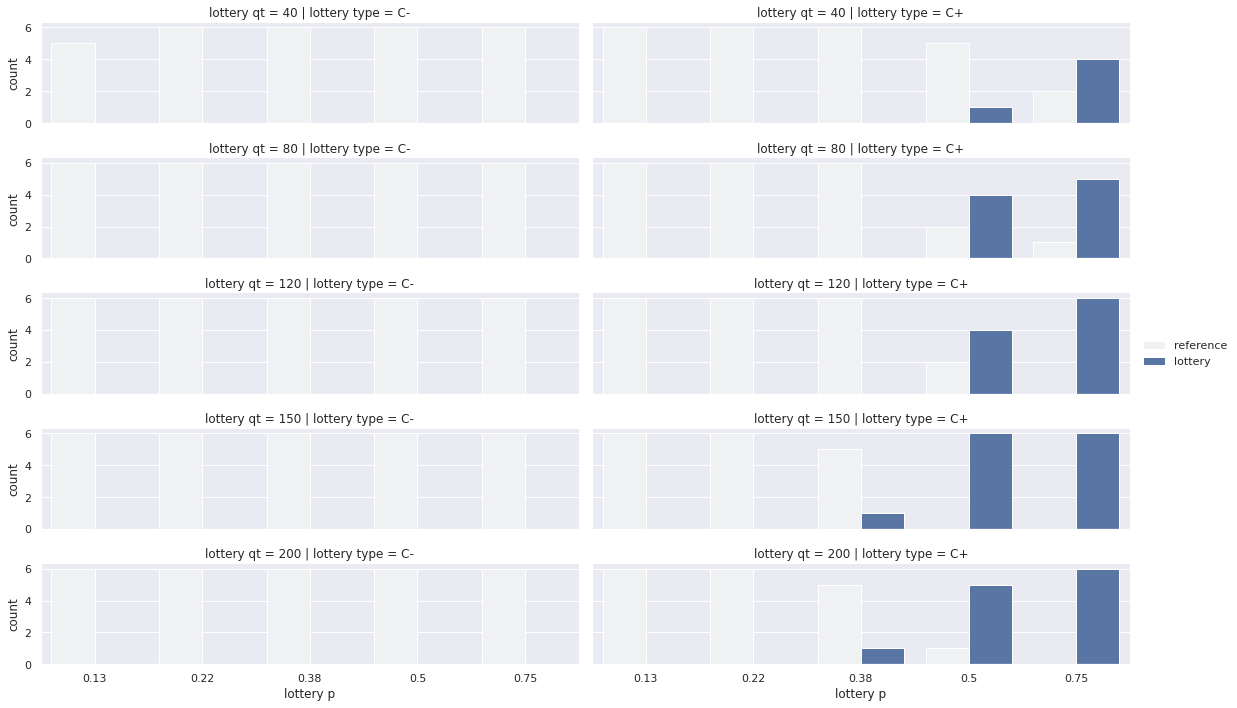

In [ ]:
def countplot(x, hue,  **kwargs):
    sns.countplot(x=x, hue = hue, **kwargs)

grid = sns.FacetGrid(data=df_mixedType, row = 'lottery qt', col = 'lottery type',size=2,aspect=4)
fig = grid.map_dataframe(sns.countplot, x='lottery p', hue = 'chosen option', hue_order = ['reference', 'lottery'])
fig.add_legend()

In [ ]:
tmp = pd.read_json('/content/nutre001_day2_neuroEcon_1670951606.json')
sns.set_theme(font_scale = 1)
def get_choice_side(row):
  if row['choice'] == 1:
    reward = 'reference'
  elif row['choice'] == 2:
    reward = 'lottery'
  else:
    reward = ''

  return reward

tmp['chosen reward'] = tmp.apply(lambda row: get_choice_side(row), axis = 1)
tmp.drop(columns=['Day', 'optionTime', 'choiceTime', 'feedbackTime', 'User'])

,Trial,Trial ID,Trial Type,block,choice,choiceStart_ms,choiceTime_ms,lottery flavor,lottery p,lottery qt,lottery shape,lottery type,reference flavor,reference p,reference qt,reference shape,reference type,trialStartTimestamp,trialStart_ms,chosen reward
0,1,10,same,0,1,11012,11237,,0.13,5,,money,,1.00,1.0,,money,1670951614,9019,reference
1,2,22,same,0,2,13983,14081,,0.38,20,,money,,1.00,1.0,,money,1670951617,11988,lottery
2,3,34,same,0,1,16826,16978,flavorA,0.75,40,flavorA_shape,C+,flavorA,1.00,20.0,flavorA_shape,C+,1670951620,14834,reference
3,4,43,same,0,2,19710,19855,flavorA,0.50,120,flavorA_shape,C+,flavorA,1.00,20.0,flavorA_shape,C+,1670951623,17725,lottery
4,5,53,same,0,1,22614,22644,flavorB,0.50,20,flavorB_shape,C-,flavorB,1.00,20.0,flavorB_shape,C-,1670951626,20608,reference
5,6,71,same,0,2,25397,25476,flavorB,0.22,200,flavorB_shape,C-,flavorB,1.00,20.0,flavorB_shape,C-,1670951628,23391,lottery
6,7,75,mixed,1,1,33407,33498,flavorA,0.13,40,flavorA_shape,C+,,1.00,0.2,,money,1670951636,31407,reference
7,8,89,mixed,1,2,36242,36248,flavorA,0.75,120,flavorA_shape,C+,,1.00,0.2,,money,1670951639,34245,lottery
8,9,102,mixed,1,1,38996,39075,flavorB,0.38,40,flavorB_shape,C-,,1.00,0.2,,money,1670951642,37001,reference
9,10,123,mixed,1,2,41820,41911,flavorB,0.50,200,flavorB_shape,C-,,1.00,0.2,,money,1670951645,39822,lottery
